## Text Classification of Drug Effectiveness from Customer Review

#### Purpose: Predict the effectiveness Level of Drugs from drug takers' feedbacks (including benefit reviews and overall comments)

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from time import time
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [3]:
# disable chaining warning
pd.options.mode.chained_assignment = None

#### Data source: Drug Review Dataset (Druglib.com) Data Set (https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Druglib.com%29)

Citation: Felix Gräßer, Surya Kallumadi, Hagen Malberg, and Sebastian Zaunseder. 2018. Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning. In Proceedings of the 2018 International Conference on Digital Health (DH '18). ACM, New York, NY, USA, 121-125. DOI: [Web Link]

In [4]:
# Import dataset
train_file = 'data/drugLibTrain_raw.tsv'
test_file = 'data/drugLibTest_raw.tsv'
train_raw = pd.read_csv(train_file, sep='\t')
print('train data:')
print(train_raw.head(5))

test_raw = pd.read_csv(test_file,sep='\t')
print('\nTest data:')
print(test_raw.head(5))

train data:
   Unnamed: 0       urlDrugName  rating         effectiveness  \
0        2202         enalapril       4      Highly Effective   
1        3117  ortho-tri-cyclen       1      Highly Effective   
2        1146           ponstel      10      Highly Effective   
3        3947          prilosec       3  Marginally Effective   
4        1951            lyrica       2  Marginally Effective   

           sideEffects                               condition  \
0    Mild Side Effects  management of congestive heart failure   
1  Severe Side Effects                        birth prevention   
2      No Side Effects                        menstrual cramps   
3    Mild Side Effects                             acid reflux   
4  Severe Side Effects                            fibromyalgia   

                                      benefitsReview  \
0  slowed the progression of left ventricular dys...   
1  Although this type of birth control has more c...   
2  I was used to having cramps s

In [5]:
# Obtain useful features for training and testing
## Assume side effect != effectiveness of drugs, hence exclude side effect and side effect reviews
## Only focus on the effectiveness of drugs (not the overall ratings)
train_df_raw = train_raw[['effectiveness','benefitsReview','commentsReview']] 
test_df_raw = test_raw[['effectiveness','benefitsReview','commentsReview']] 

# print result
train_df_raw.head(5)


,effectiveness,benefitsReview,commentsReview
0,Highly Effective,slowed the progression of left ventricular dys...,"monitor blood pressure , weight and asses for ..."
1,Highly Effective,Although this type of birth control has more c...,"I Hate This Birth Control, I Would Not Suggest..."
2,Highly Effective,I was used to having cramps so badly that they...,I took 2 pills at the onset of my menstrual cr...
3,Marginally Effective,The acid reflux went away for a few months aft...,I was given Prilosec prescription at a dose of...
4,Marginally Effective,I think that the Lyrica was starting to help w...,See above


### Data Pre-Processing

In [7]:
# Check data quality

print(train_df_raw.info())
print(test_df_raw.info())

# keep dataset not null
train_df_raw.dropna(axis=0, how='any',inplace=True)
test_df_raw.dropna(axis=0, how='any',inplace=True)
print(train_df_raw.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3099 entries, 0 to 3106
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   effectiveness   3099 non-null   object
 1   benefitsReview  3099 non-null   object
 2   commentsReview  3099 non-null   object
dtypes: object(3)
memory usage: 96.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1036 entries, 0 to 1035
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   effectiveness   1036 non-null   object
 1   benefitsReview  1036 non-null   object
 2   commentsReview  1036 non-null   object
dtypes: object(3)
memory usage: 32.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3099 entries, 0 to 3106
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   effectiveness   3099 non-null   object
 1   benefitsRevie

In [8]:
# transform effectiveness into numeric/ ordinal variable into 3 levels as scholar papers suggested
print(train_df_raw.effectiveness.value_counts())
effectiveness_mapping = {'Highly Effective': 2, 'Considerably Effective':2, "Ineffective":0, 'Marginally Effective':1,'Moderately Effective':1}


# Show data distribution / balancy of dataset
print(train_df_raw.effectiveness.value_counts(normalize=True))
print(test_df_raw.effectiveness.value_counts(normalize=True))
## data distribution of test and train dataset are similar
## imbalance class on level 1 & 2, to be solved data after text extraction

Highly Effective          1328
Considerably Effective     925
Moderately Effective       414
Ineffective                246
Marginally Effective       186
Name: effectiveness, dtype: int64
Highly Effective          0.428525
Considerably Effective    0.298483
Moderately Effective      0.133591
Ineffective               0.079380
Marginally Effective      0.060019
Name: effectiveness, dtype: float64
Highly Effective          0.396718
Considerably Effective    0.299228
Moderately Effective      0.151544
Ineffective               0.079151
Marginally Effective      0.073359
Name: effectiveness, dtype: float64


In [9]:
# import nltk module

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

tokenizer = RegexpTokenizer('\w+|^[\d\.]+|[^0-9]|\S+') # Tokenizer object
lemma = WordNetLemmatizer() # Lemmatization object
punctuations = '''!()-,[]{};:’“”'"\,,<>./?@#$%^&*_~''' # punctuation 
stopwords = stopwords.words('english') # obtain nltk ver. stopwords
drugsName = list(train_raw.urlDrugName.unique()) # list of drugs name
conditions = list(train_raw.condition.unique()) # list of medical condition
extra = ['would','will','also']

punctuations_list = [p for p in punctuations] # create punctuation list

# Remove stopwords that may remove negative sentiment 
remove_stopwords = ['not','no','very',"don't","ain",'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't","won't", 'wouldn', "wouldn't"]    

for r in remove_stopwords:
    stopwords.remove(r)

# Check stopwords
unwanted_word = stopwords + punctuations_list +extra + drugsName + conditions # Remove influence of drug used and medical terms of condition
print(unwanted_word[0:200])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 's', 't

In [10]:
# Text extraction from comments
from nltk.corpus import wordnet as wn
import re 
from sklearn.feature_extraction.text import TfidfVectorizer
# Create functions

def hasNumbers(inputString):
    return not(bool(re.search(r'\d', inputString)))

def word_extraction(text):
    word_list = tokenizer.tokenize(text) # tranform word in list
    useWord_list =[]
    for word in word_list:
        word = word.lower() # set word to lowercase 
        if (word not in unwanted_word) & (len(word)>2) & (hasNumbers(word)): # remove unwanted words / words with single character / words with dose amount
            word = lemma.lemmatize(word,wn.NOUN) # lemmatize by noun
            word = lemma.lemmatize(word,wn.VERB) # lemmatize by verb
            word = lemma.lemmatize(word,wn.ADJ) # lemmatize by adj
            useWord_list.append(word)
    text = ' '.join(useWord for useWord in useWord_list) # recreate the text sentence for count vectorizing
    return text    

def Train_Vectorizer(training_data,textCol1,textCol2,max_feature,min_count=2):
    textSeries1 = training_data[textCol1]
    textSeries2 = training_data[textCol2] 
    textSeries = textSeries1 + textSeries2 # combine the two columns with text comments
    textSeries = list(textSeries.map(word_extraction)) # words extraction and cleaning
    vectorizer = TfidfVectorizer(analyzer='word',token_pattern='\w+|\d|\S+',min_df=min_count,max_features=max_feature).fit(textSeries) # Vectorizer object to TF-IDF values
    return vectorizer

def text_preprocess(df, vectorizer,labelCol='effectiveness',textCol1='commentsReview',textCol2='benefitsReview'): # input data to pre-process with the trained vectorizer
    df['effectiveness_ordinal'] = df[labelCol].map(effectiveness_mapping)
    df.reset_index(inplace=True,drop=True)
    textSeries1 = df[textCol1]
    textSeries2 = df[textCol2] 
    label = df[['effectiveness_ordinal']] # obtain the label
    textSeries = textSeries1 + textSeries2 # combine the two columns with text comments
    textSeries = list(textSeries.map(word_extraction)) # words extraction and cleaning    
    count_vector = vectorizer.transform(textSeries).toarray() # obtain word count per combined comment
    feature = vectorizer.get_feature_names() # obtain words
    vector_df = pd.DataFrame(data=count_vector, columns=feature) # build dataframe for storing word vector
    df = pd.concat([vector_df,label],axis=1) # concat with original dataset
    return df

## SVM Model 

In [11]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics

### Pre-Process raw text training data

In [12]:
target_names = ['Ineffective',
 'Marginally Effective/ Moderately Effective','Highly Effective/ Considerably Effective']
label = [0,1,2]
full_raw = pd.concat([train_df_raw,test_df_raw],axis=0)

In [15]:
# for comparison with MLP model, same pre-processed data is adapt in SVM model
min_count =3
max_feature = 3000

vectorizer = Train_Vectorizer(full_raw,'commentsReview','benefitsReview', max_feature=max_feature, min_count=min_count)
feature = vectorizer.get_feature_names()

#Calculate the TF-IDF score of training data
df_train = text_preprocess(train_df_raw,vectorizer,'effectiveness','commentsReview','benefitsReview')

In [16]:
df_train.shape

(3099, 3001)

In [17]:
df_train.head()

,abate,abcess,abdomen,abdominal,ability,able,abnormal,abnormality,abovei,abruptly,...,young,youth,yr,zanaflex,zap,zero,zetia,zombie,zone,effectiveness_ordinal
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.654918,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


#### Create a Stratified K-Fold Cross Validation where fold =5

In [18]:
datasize = df_train.shape[0]
cv = 5
kFold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=123)

In [14]:
cols = ['id','Model','Cross_Validation','Kernel','degree','gamma','regularization','trainingTime','Training_Accuracy','Generalization_Accuracy','Fscore_class0','Fscore_class1','Fscore_class2']
#SVM_result = pd.read_csv('SVM_result.csv')
#SVM_result_Linear =pd.read_csv('SVM_result_Linear.csv')

In [19]:
# Chart to display the varaition of accuracy (training/ validation) across each fold
def plot_kFold_variation(cv_num,train_accuracy, val_accuracy,Fscore_class0,Fscore_class1,Fscore_class2,title):
    fig,ax = plt.subplots(ncols=2,sharex=True,figsize=(16,5))
    x= np.arange(1,cv_num+1) # x-label
    # Show variation in accuracy
    ax[0].plot(x,train_accuracy,color='b',label='Training') # training accuracy
    ax[0].plot(x,val_accuracy,color='r',label='Validation') # validation accuracy
    ax[0].set_title('Variation in Accuracy')
    ax[0].set_xlabel('%d-Fold' %cv_num)
    ax[0].set_ylabel('Accuracy%')
    ax[0].legend()
    
    # variation in F-measure per class
    ax[1].plot(x,Fscore_class0,label='class 0',color='g')
    ax[1].plot(x,Fscore_class1,label='class 1',color='m')
    ax[1].plot(x,Fscore_class2,label='class 2',color='brown')
    ax[1].set_title('Variation in F1 Score')
    ax[1].set_xlabel('%d-Fold' %cv_num)
    ax[1].set_ylabel('F1 Score')
    ax[1].legend()
    plt.suptitle(title)
    plt.show()  
    name = title.replace(' ','_').replace('=','_').replace('-','_').replace('\n','').replace('|','_')
    fig.savefig('chart/{}.jpg'.format(name)) # save figure


In [20]:
# Train the classifier of different SVM Kernel

def crossValidateSVM(x_train,y_train,kerneltype, cvModel,degree=3,gamma='scale',regularizationC=1,graph = True, class_weight = None):
    cv_fold = cvModel.split(x_train,y_train) # get cross validation model
    cv = kFold.n_splits # get k-fold value
    
    f1_0 = []  # empty list for storing performance metric details of each fold
    f1_1 = []
    f1_2 = []
    train_accuracy = []
    val_accuracy = []
    
    initime = time() # record time
    print('-----Start Training-----')
    ID = 'SVM_cv%d_kernel_%s_degree%d_gamma%s_regular%d'%(cv,kerneltype,degree,gamma,regularizationC) # ID for record
    for fold_id, (train_idx, val_idx) in enumerate(cv_fold): # start cross-validating
        # prepare data
        train_x = x_train.loc[train_idx,:]
        val_x = x_train.loc[val_idx,:]
        train_y = y_train[train_idx]
        val_y = y_train[val_idx]
        
        size = train_x.shape[0] # size of training data in this fold
        over_proportion = '0.4;0.3;1' 
        over_target = dict(zip([0,1,2], [ int(x*size) for x in  [0.4,0.3,1]])) # create dict to indicate oversampling target size from the given ratio
        over = SMOTE(random_state=123,sampling_strategy=over_target,k_neighbors=5) # create SMOTE object
        train_x,train_y = over.fit_resample(train_x,train_y) # over-sample training data in this fold
        
        # generate model
        svm_mdl = SVC(kernel = kerneltype,random_state=123,degree=degree,gamma=gamma,C=regularizationC, class_weight = class_weight)
        classifier = OneVsRestClassifier(svm_mdl) # classifier to preform multi-class (One Vs rest approach)
        print("-----Cross-Validating --- %d/%d--Fold---------------------" %(fold_id+1,cv))
      
        classifier.fit(train_x, train_y) # fitting data
        y_pred_train = classifier.predict(train_x) # predict training label
        
        # metric calculation
        cvtrain_accuracy = metrics.accuracy_score(train_y,y_pred_train) # training accuracy
        train_accuracy.append(cvtrain_accuracy) # append in list
        y_pred_val = classifier.predict(val_x) # predict validation data in this fold
        cv_val_accuracy = metrics.accuracy_score(val_y,y_pred_val) # validation accuracy
        val_accuracy.append(cv_val_accuracy) # append in list
        # calculate F1 score Per class
        f1_class0 = metrics.f1_score(val_y,y_pred_val,average='macro',labels=[0],zero_division=0)
        f1_class1 = metrics.f1_score(val_y,y_pred_val,average='macro',labels=[1],zero_division=0)
        f1_class2 = metrics.f1_score(val_y,y_pred_val,average='macro',labels=[2],zero_division=0)
        f1_0.append(f1_class0)
        f1_1.append(f1_class1)
        f1_2.append(f1_class2)
        print('---Training of %d/%d CV Fold completed, training accuracy = %.2f, validation accuracy = %2f' %(fold_id+1,cv,cvtrain_accuracy,cv_val_accuracy))
        print('F1 Score:   Class 0: %.2f |  Class 1: %.2f | Class 2: %.2f'%(f1_class0, f1_class1, f1_class2))  
        
    endtime = time() - initime # record training time
    print('Model Training is completed')
    print('training time: %d seconds' % endtime)
    print('---Average Training Accuracy: %.2f | Average Validation Accuracy: %.2f' %(sum(train_accuracy)/cv,sum(val_accuracy)/cv))
    print('Average F1 Score:')
    print('Class 0: %.2f |  Class 1: %.2f | Class 2: %.2f'%( sum(f1_0)/cv, sum(f1_1)/cv, sum(f1_2)/cv))
    if graph: # set a parameter in case the grid search is too large to display all graphs
        title = 'K-Fold Variation of SVM Model - %s Kernel \nDegree = %d | Gamma = %s' % (kerneltype,degree,str(gamma))
        plot_kFold_variation(cv,train_accuracy,val_accuracy,f1_0,f1_1,f1_2,title) # plot graph
    result = [ID,'SVM',cv,kerneltype,degree,gamma,regularizationC,endtime,sum(train_accuracy)/cv,sum(val_accuracy)/cv,sum(f1_0)/cv,sum(f1_1)/cv,sum(f1_2)/cv] # return a list with every information
    return result,classifier

In [21]:
# get the labels and data
x_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]

### Baseline Model of Polynomial

-----Start Training-----


C:\Users\Hillie\anaconda3\lib\site-packages\imblearn\utils\_validation.py:318: UserWarning: After over-sampling, the number of samples (2479) in class 2 will be larger than the number of samples in the majority class (class #2 -> 1802)
  warnings.warn(
C:\Users\Hillie\anaconda3\lib\site-packages\imblearn\utils\_validation.py:318: UserWarning: After over-sampling, the number of samples (2479) in class 2 will be larger than the number of samples in the majority class (class #2 -> 1802)
  warnings.warn(
C:\Users\Hillie\anaconda3\lib\site-packages\imblearn\utils\_validation.py:318: UserWarning: After over-sampling, the number of samples (2479) in class 2 will be larger than the number of samples in the majority class (class #2 -> 1802)
  warnings.warn(
C:\Users\Hillie\anaconda3\lib\site-packages\imblearn\utils\_validation.py:318: UserWarning: After over-sampling, the number of samples (2479) in class 2 will be larger than the number of samples in the majority class (class #2 -> 1803)
  war

Model Training is completed
training time: 930 seconds
---Average Training Accuracy: 0.96 | Average Validation Accuracy: 0.73
Average F1 Score:
Class 0: 0.05 |  Class 1: 0.04 | Class 2: 0.84


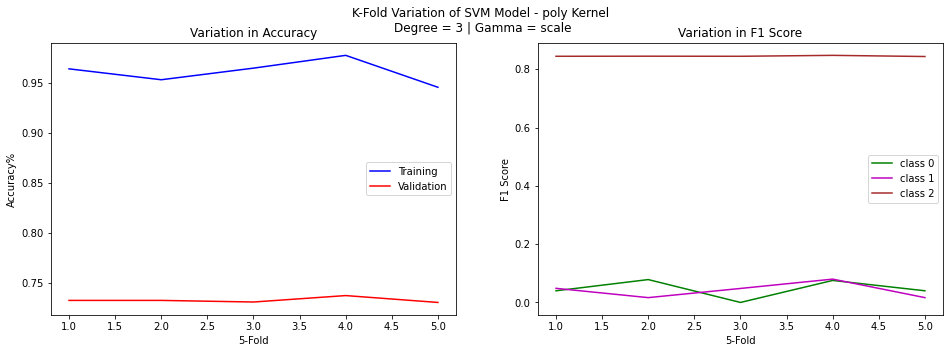

In [21]:
## class_weight = None (solely depend on SMOTE)
result, classifier = crossValidateSVM(x_train,y_train,'poly', cvModel = kFold,degree=3,gamma='scale',regularizationC=1)

-----Start Training-----
Model Training is completed
training time: 930 seconds
---Average Training Accuracy: 0.97 | Average Validation Accuracy: 0.73
Average F1 Score:
Class 0: 0.06 |  Class 1: 0.05 | Class 2: 0.85


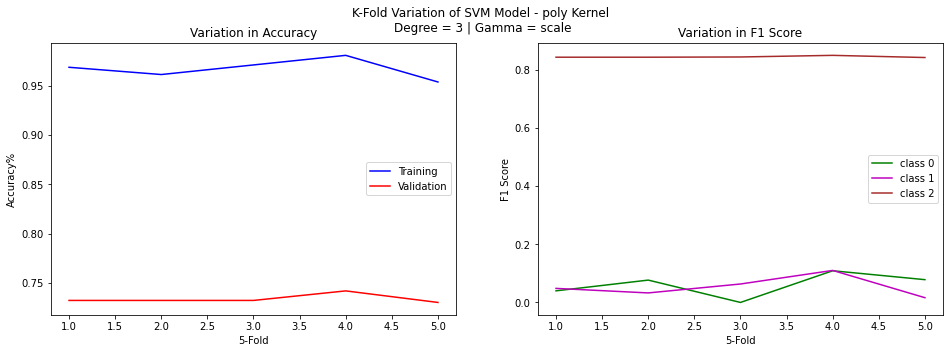

In [23]:
# Baseline Model with class weight set as balanced
result, classifier = crossValidateSVM(x_train,y_train,'poly', cvModel = kFold,degree=3,gamma='scale',regularizationC=1,class_weight = 'balanced')

### Baseline Model of RBF Kernel

-----Start Training-----
Model Training is completed
training time: 847 seconds
---Average Training Accuracy: 0.98 | Average Validation Accuracy: 0.74
Average F1 Score:
Class 0: 0.19 |  Class 1: 0.11 | Class 2: 0.85


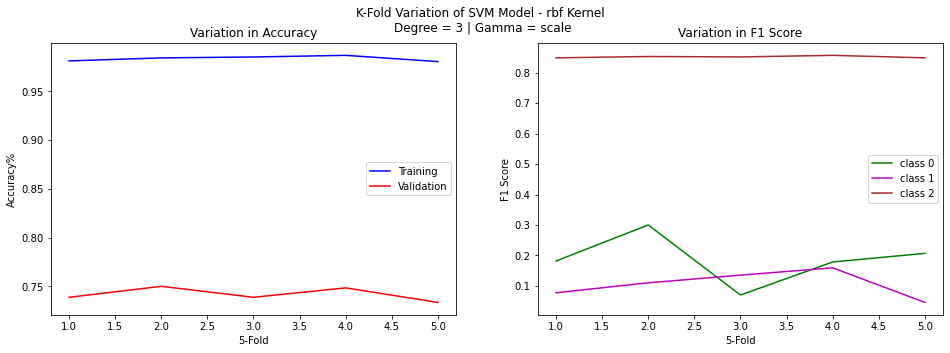

In [26]:
# Baseline Model (class_weight = None)
result_rbf, classifier_rbf = crossValidateSVM(x_train,y_train,'rbf', cvModel = kFold,gamma='scale',regularizationC=1)

-----Start Training-----
Model Training is completed
training time: 912 seconds
---Average Training Accuracy: 0.99 | Average Validation Accuracy: 0.75
Average F1 Score:
Class 0: 0.22 |  Class 1: 0.21 | Class 2: 0.86


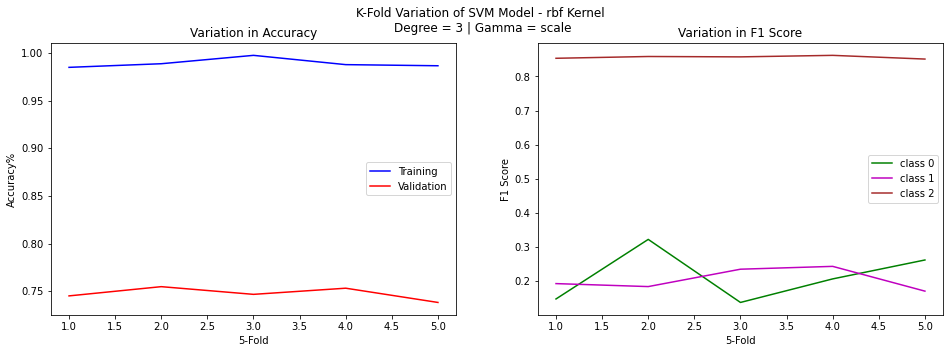

In [27]:
# Baseline Model (class_weight = 'balanced')
result_rbf, classifier_rbf_balanced = crossValidateSVM(x_train,y_train,'rbf', cvModel = kFold,gamma='scale',regularizationC=1,class_weight = 'balanced')

### Baseline Model for Linear Kernel

-----Start Training-----
Model Training is completed
training time: 516 seconds
---Average Training Accuracy: 0.92 | Average Validation Accuracy: 0.72
Average F1 Score:
Class 0: 0.33 |  Class 1: 0.22 | Class 2: 0.84


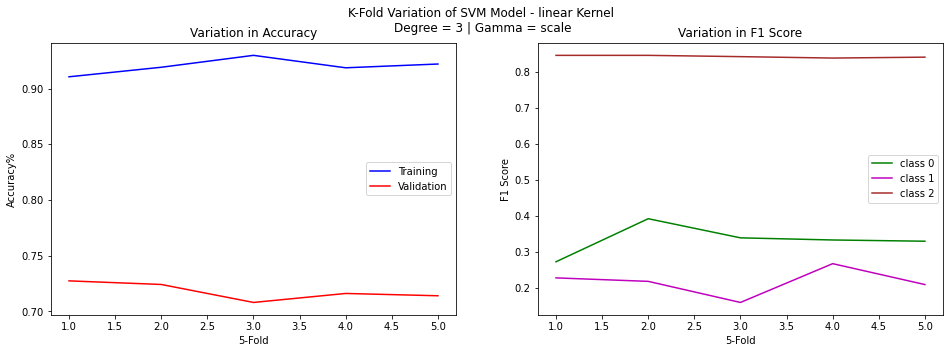

['SVM_cv5_kernel_linear_degree3_gammascale_regular1',
 'SVM',
 5,
 'linear',
 3,
 'scale',
 1,
 516.5417940616608,
 0.9199731359202181,
 0.7179722757830007,
 0.33355331840975927,
 0.21645666158962804,
 0.8438803691079505]

In [28]:
# Baseline Model
## class weight = None
result_linear, classifier_linear = crossValidateSVM(x_train,y_train,'linear', cvModel = kFold,gamma='scale',regularizationC=1 )
result_linear

-----Start Training-----
Model Training is completed
training time: 865 seconds
---Average Training Accuracy: 0.99 | Average Validation Accuracy: 0.75
Average F1 Score:
Class 0: 0.22 |  Class 1: 0.21 | Class 2: 0.86


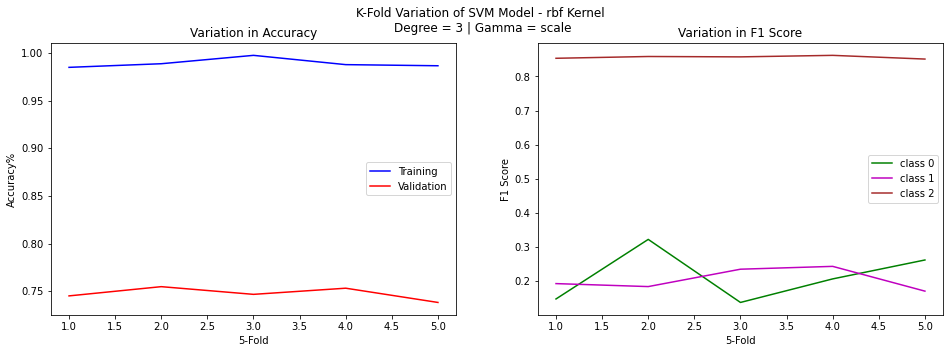

In [29]:
# class weight ='balanced'
result_linear_balanced, classifier_linear_balanced = crossValidateSVM(x_train,y_train,'rbf', cvModel = kFold,gamma='scale',regularizationC=1,class_weight = 'balanced')

In [31]:
result_linear_balanced

['SVM_cv5_kernel_rbf_degree3_gammascale_regular1',
 'SVM',
 5,
 'rbf',
 3,
 'scale',
 1,
 865.1464574337006,
 0.9889883959065889,
 0.7476575121163166,
 0.21557029229670963,
 0.20548742084243585,
 0.8561487757848706]

In [22]:
# define a function to show the tuning results of One Single Parameter
## particularly for repeating results for few times and display error bar
## also useful if no repetition is done (no error bar is shown)
def plot_parameter_result(parameter_Name, tempData):
    data = tempData[[parameter_Name,'Generalization_Accuracy','Training_Accuracy','Fscore_class0','Fscore_class1','Fscore_class2','trainingTime']]
    data_group = data.groupby(parameter_Name).agg(['median','min','max']).reset_index() # assume the result is completed for at few times
    colors = ['#006d2c','#08589e','#e7298a'] # assign color
    ecolors = ['#ccece6','#c6dbef','#d4b9da'] # assign error bar color
    title = ['Accuracy%','F1 Score Per Class','training time (s)']
    fig, ax = plt.subplots(figsize=(21,5),ncols=3)
    
    for i in range(3): # 3 subplots
        if i ==0:
            m=['Generalization_Accuracy','Training_Accuracy'] # metric in ax[0]
        elif i==1:
            m=['Fscore_class0','Fscore_class1','Fscore_class2'] # metric in ax[1]
        else:
            m=['trainingTime']       # metric in ax[2]
        for l in range(len(m)):
            y = data_group[m[l]]['median']
            yerr = [(data_group.shape[0])*[0]]*2 # empty list for storing error bar information
            yerr[0] = y- data_group[m[l]]['min'] # lower bound of error
            yerr[1]  = data_group[m[l]]['max'] - y # upper bound of error
            ax[i].errorbar(data_group[parameter_Name],y,yerr =yerr,fmt='o',color=colors[l], ecolor=ecolors[l], elinewidth=3, label=m[l],capsize=1,ls='-')
        ax[i].set_xlabel(parameter_Name)
        ax[i].legend()    
        ax[i].set_title(title[i])
    plt.suptitle('Performance Metric of '+ parameter_Name+' upon Iterations')
    plt.show()
    fig.savefig('chart/SVM_Train_{}.jpg'.format(parameter_Name)) # save figure

In [23]:
# design a classifier for training that offers more flexbility in tuning Linear Kernel
from sklearn.svm import LinearSVC
def crossValidateSVM_Linear(x_train,y_train,cvModel, penalty = 'l2', loss = 1, dual = True,regularizationC=1,graph = True, class_weight = None):
    cv_fold = cvModel.split(x_train,y_train)
    cv = kFold.n_splits
    
    f1_0 = []
    f1_1 = []
    f1_2 = []
    train_accuracy = []
    val_accuracy = []
    loss_parameter = ['hinge', 'squared_hinge']
    
    initime = time() # record time
    #print('-----Start Training-----')
    ID = 'SVM_cv%s_loss_%s_penalty%s_regular%d'%(cv,loss_parameter[loss],penalty,regularizationC)
    for fold_id, (train_idx, val_idx) in enumerate(cv_fold):
        # prepare data
        train_x = x_train.loc[train_idx,:]
        val_x = x_train.loc[val_idx,:]
        train_y = y_train[train_idx]
        val_y = y_train[val_idx]
        
        size = train_x.shape[0]
        over_proportion = '0.2;0.2;1'
        over_target = dict(zip([0,1,2], [ int(x*size) for x in  [0.4,0.3,1]]))
        over = SMOTE(random_state=123,sampling_strategy=over_target,k_neighbors=5)
        train_x,train_y = over.fit_resample(train_x,train_y)
        
        # generate model
        svm_mdl = LinearSVC(random_state=123, C=regularizationC, class_weight = class_weight,dual=dual,loss=loss_parameter[loss],penalty=penalty)
        classifier = OneVsRestClassifier(svm_mdl)
        #print("-----Cross-Validating --- %d/%d--Fold---------------------" %(fold_id+1,cv))
      
        classifier.fit(train_x, train_y) # fitting data
        y_pred_train = classifier.predict(train_x)
        
        # metric calculation
        cvtrain_accuracy = metrics.accuracy_score(train_y,y_pred_train) # training accuracy
        train_accuracy.append(cvtrain_accuracy)
        y_pred_val = classifier.predict(val_x)
        cv_val_accuracy = metrics.accuracy_score(val_y,y_pred_val) # validation accuracy
        val_accuracy.append(cv_val_accuracy)
        f1_class0 = metrics.f1_score(val_y,y_pred_val,average='macro',labels=[0],zero_division=0)
        f1_class1 = metrics.f1_score(val_y,y_pred_val,average='macro',labels=[1],zero_division=0)
        f1_class2 = metrics.f1_score(val_y,y_pred_val,average='macro',labels=[2],zero_division=0)
        f1_0.append(f1_class0)
        f1_1.append(f1_class1)
        f1_2.append(f1_class2)
        #print('---Training of %d/%d CV Fold completed, training accuracy = %.2f, validation accuracy = %2f' %(fold_id+1,cv,cvtrain_accuracy,cv_val_accuracy))
        #print('F1 Score:   Class 0: %.2f |  Class 1: %.2f | Class 2: %.2f'%(f1_class0, f1_class1, f1_class2))  
        
    endtime = time() - initime
    #print('Model Training is completed')
    print('training time: %d seconds' % endtime)
    print('---Average Training Accuracy: %.2f | Average Validation Accuracy: %.2f' %(sum(train_accuracy)/cv,sum(val_accuracy)/cv))
    print('Average F1 Score:')
    print('Class 0: %.2f |  Class 1: %.2f | Class 2: %.2f'%( sum(f1_0)/cv, sum(f1_1)/cv, sum(f1_2)/cv))
    if graph:
        title = 'K-Fold Variation of SVM Linear Model  \n penalty = %s | loss = %s | C = %d | weight=%s' % (penalty,loss_parameter[loss],regularizationC,'True' if class_weight == 'balanced' else 'False')
        plot_kFold_variation(cv,train_accuracy,val_accuracy,f1_0,f1_1,f1_2,title)
    result = [ID,'SVM_Linear',cv,'Linear',0,0,regularizationC,endtime,sum(train_accuracy)/cv,sum(val_accuracy)/cv,sum(f1_0)/cv,sum(f1_1)/cv,sum(f1_2)/cv,loss,penalty]
    return result,classifier

### Test the Linear Kernel with combination of Loss Function and Penalty, assume C=1

In [70]:
loss_parameter = ['hinge','squared_hinge']

#### Loss= 'squared_hinge', penalty = 'l1'

training time: 10 seconds
---Average Training Accuracy: 0.96 | Average Validation Accuracy: 0.70
Average F1 Score:
Class 0: 0.33 |  Class 1: 0.31 | Class 2: 0.83


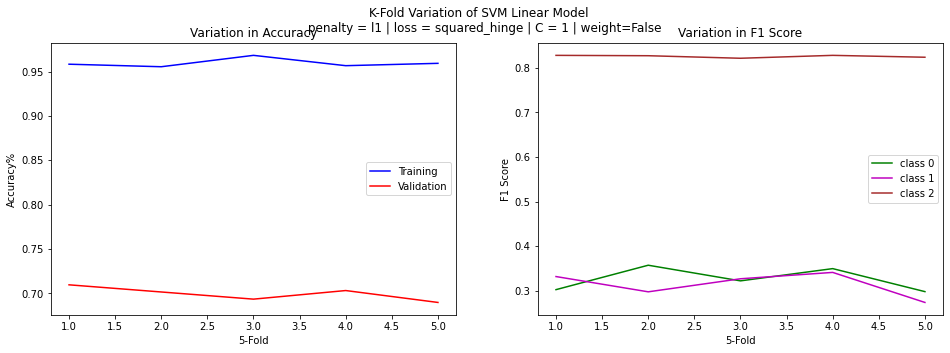

In [72]:
# Class weight = None
loss= 1 # squared_hinge
penalty = 'l1'
result, _ = crossValidateSVM_Linear(x_train,y_train, cvModel = kFold,regularizationC=1,graph=True,penalty=penalty,loss=loss,class_weight = None,dual=False)

-----Start Training-----
Model Training is completed
training time: 12 seconds
---Average Training Accuracy: 0.97 | Average Validation Accuracy: 0.66
Average F1 Score:
Class 0: 0.32 |  Class 1: 0.36 | Class 2: 0.80


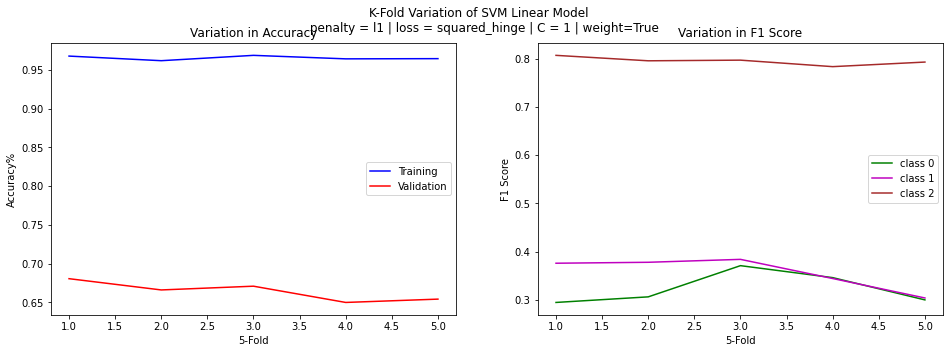

In [45]:
# Class weight = balanced
loss= 1
penalty = 'l1'
result_l1balanced, _ = crossValidateSVM_Linear(x_train,y_train, cvModel = kFold,regularizationC=1,graph=True,penalty=penalty,loss=loss,dual=False,class_weight='balanced')

#### Loss= 'squared_hinge', penalty = 'l2'

training time: 8 seconds
---Average Training Accuracy: 0.97 | Average Validation Accuracy: 0.70
Average F1 Score:
Class 0: 0.30 |  Class 1: 0.28 | Class 2: 0.83


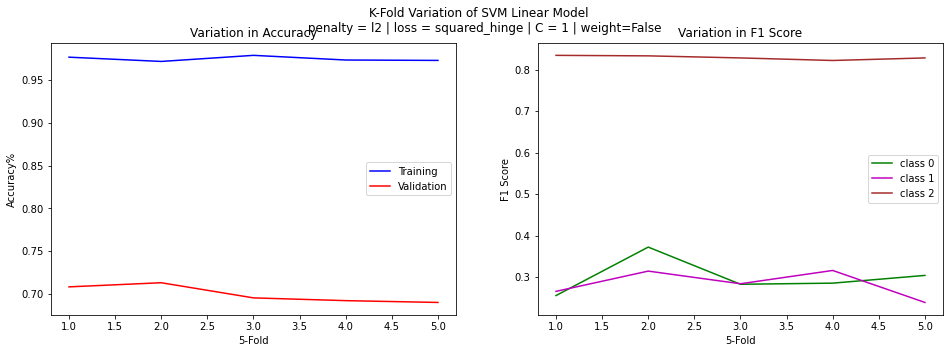

In [26]:
# Class weight = None
loss= 1 #'squared_hinge'
penalty = 'l2'
result_l2, _ = crossValidateSVM_Linear(x_train,y_train, cvModel = kFold,regularizationC=1,graph=True,penalty=penalty,loss=loss,class_weight = None,dual=False)

training time: 8 seconds
---Average Training Accuracy: 0.98 | Average Validation Accuracy: 0.67
Average F1 Score:
Class 0: 0.31 |  Class 1: 0.35 | Class 2: 0.80


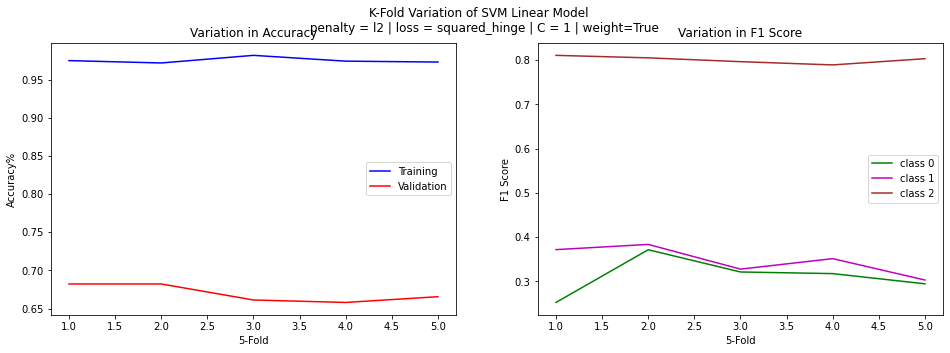

In [74]:
# Class weight = balanced
loss= 1 #'squared_hinge'
penalty = 'l2'
result_l2, _ = crossValidateSVM_Linear(x_train,y_train, cvModel = kFold,regularizationC=1,graph=True,penalty=penalty,loss=loss,class_weight = 'balanced',dual=True)

#### Loss= 'hinge', penalty = 'l2'

training time: 10 seconds
---Average Training Accuracy: 0.92 | Average Validation Accuracy: 0.72
Average F1 Score:
Class 0: 0.33 |  Class 1: 0.22 | Class 2: 0.84


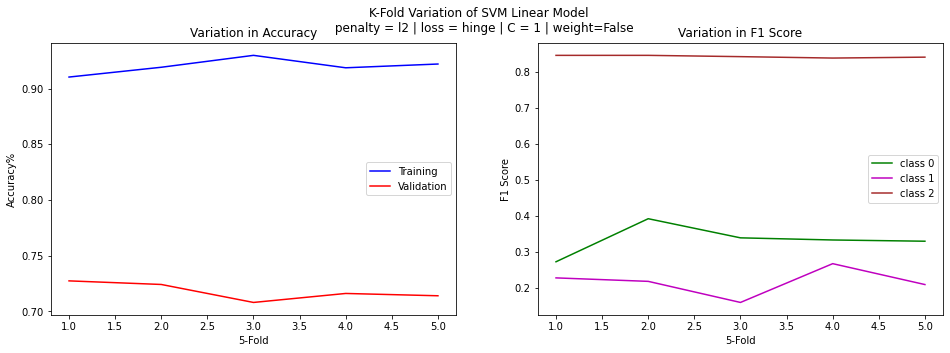

In [25]:
# Class weight = None
loss= 0 # hinge
penalty = 'l2'
result_l2, _ = crossValidateSVM_Linear(x_train,y_train, cvModel = kFold,regularizationC=1,graph=True,penalty=penalty,loss=loss,class_weight = None,dual=True)

training time: 9 seconds
---Average Training Accuracy: 0.93 | Average Validation Accuracy: 0.67
Average F1 Score:
Class 0: 0.33 |  Class 1: 0.35 | Class 2: 0.80


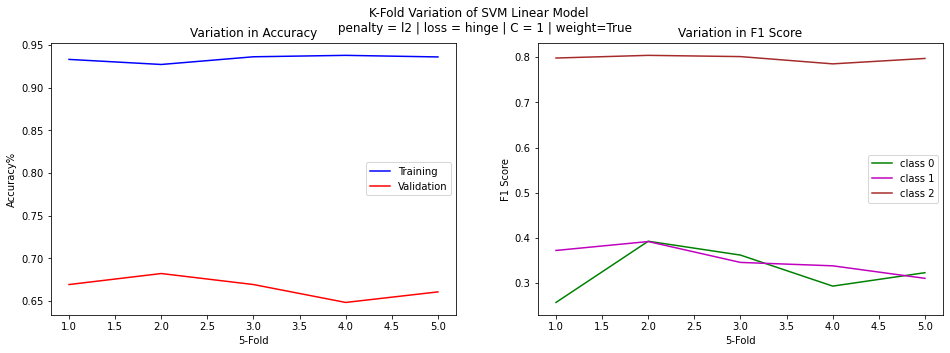

In [75]:
# Class weight = 'balanced'
loss= 0 # hinge
penalty = 'l2'
result_l2, _ = crossValidateSVM_Linear(x_train,y_train, cvModel = kFold,regularizationC=1,graph=True,penalty=penalty,loss=loss,class_weight = 'balanced',dual=True)

In [44]:
# plot a 3D graph to show results of Grid search
def plot_3D(parameter_NameA, parameter_NameB,tempData,angles=(20,30)):
    data = tempData[[parameter_NameA,parameter_NameB, 'Generalization_Accuracy','Training_Accuracy','Fscore_class0','Fscore_class1','Fscore_class2','trainingTime']].sort_values(by=[parameter_NameA],ascending=True)
    cmapList = ['Blues','Reds','copper_r']
    title = ['Accuracy%','F1 Score Per Class','training time (s)']
    fig, ax = plt.subplots(figsize=(27,12),ncols=3,subplot_kw={"projection": "3d"},sharex=True)
    y_valuesB = data[parameter_NameB].unique()
    y_valuesA = data[parameter_NameA].unique()
    X, Y = np.meshgrid(np.array(y_valuesA), np.array(y_valuesB))
    X = X.astype('float64')
    for i in range(3): # 3 subplots
        if i ==0:
            m=['Training_Accuracy','Generalization_Accuracy']
        elif i==1:
            m=['Fscore_class0','Fscore_class1','Fscore_class2']
        else:
            m=['trainingTime']       
        for l in range(len(m)):
            Z = [[0]*len(y_valuesA)]*len(y_valuesB) # Create empty matrix
            for w in range(len(y_valuesB)):
                Z[w] = data.loc[data[parameter_NameB]==data[parameter_NameB][w],m[l]]
            Z=np.array(Z)
            surf = ax[i].plot_surface(X,Y,Z,label=m[l],cmap=cmapList[l], antialiased=True, linewidth=10,vmin=Z.min(),vmax=Z.max())
            cbar = fig.colorbar(surf, ax=ax[i],orientation='horizontal',pad=len(m)/500)
            cbar.ax.set_title(m[l])                  
        ax[i].set_xlabel(parameter_NameA)
        ax[i].set_ylabel(parameter_NameB)   
        ax[i].set_title(title[i],fontsize=13)
        ax[i].view_init(angles[0], angles[1]) 
    plt.suptitle('Grid Search '+ parameter_NameA + ' and '+ parameter_NameB,fontsize=15)
    plt.show()
    fig.savefig('chart/SVM_Train_{}_{}.jpg'.format(parameter_NameA,parameter_NameB))     

## Grid Search on Linear Kernel: Regularization measure "C" and Loss Function ['hinge','squared_hinge']

----lossFunc = 1, regularization = 0.001  ----------
training time: 7 seconds
---Average Training Accuracy: 0.59 | Average Validation Accuracy: 0.73
Average F1 Score:
Class 0: 0.00 |  Class 1: 0.00 | Class 2: 0.84
----lossFunc = 1, regularization = 0.021  ----------
training time: 8 seconds
---Average Training Accuracy: 0.59 | Average Validation Accuracy: 0.73
Average F1 Score:
Class 0: 0.00 |  Class 1: 0.00 | Class 2: 0.84
----lossFunc = 1, regularization = 0.041  ----------
training time: 8 seconds
---Average Training Accuracy: 0.60 | Average Validation Accuracy: 0.73
Average F1 Score:
Class 0: 0.02 |  Class 1: 0.00 | Class 2: 0.84
----lossFunc = 1, regularization = 0.061  ----------
training time: 8 seconds
---Average Training Accuracy: 0.64 | Average Validation Accuracy: 0.73
Average F1 Score:
Class 0: 0.11 |  Class 1: 0.00 | Class 2: 0.84
----lossFunc = 1, regularization = 0.081  ----------
training time: 8 seconds
---Average Training Accuracy: 0.68 | Average Validation Accuracy: 

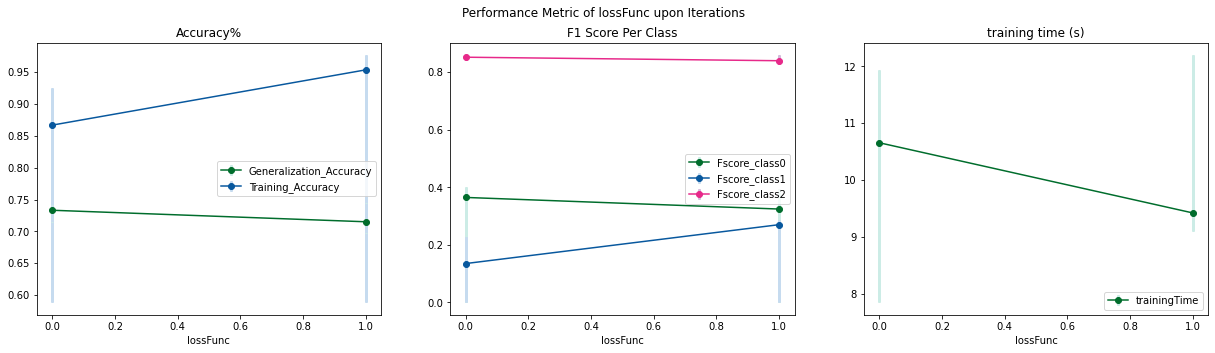

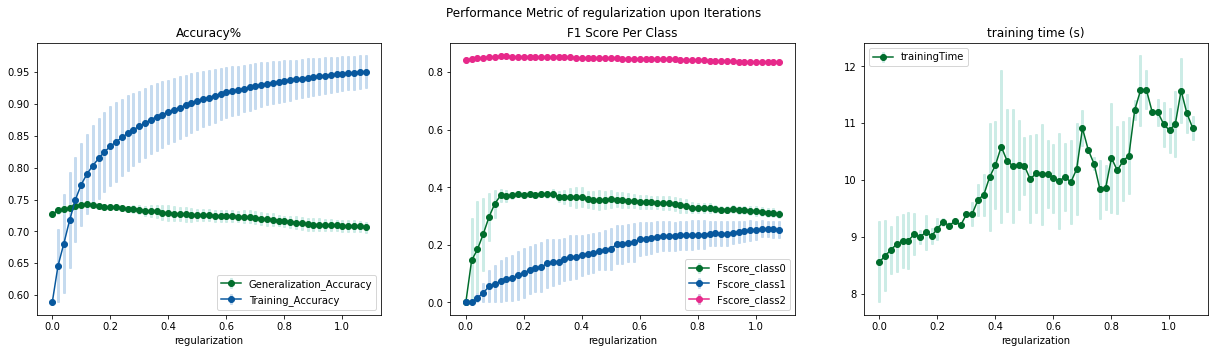

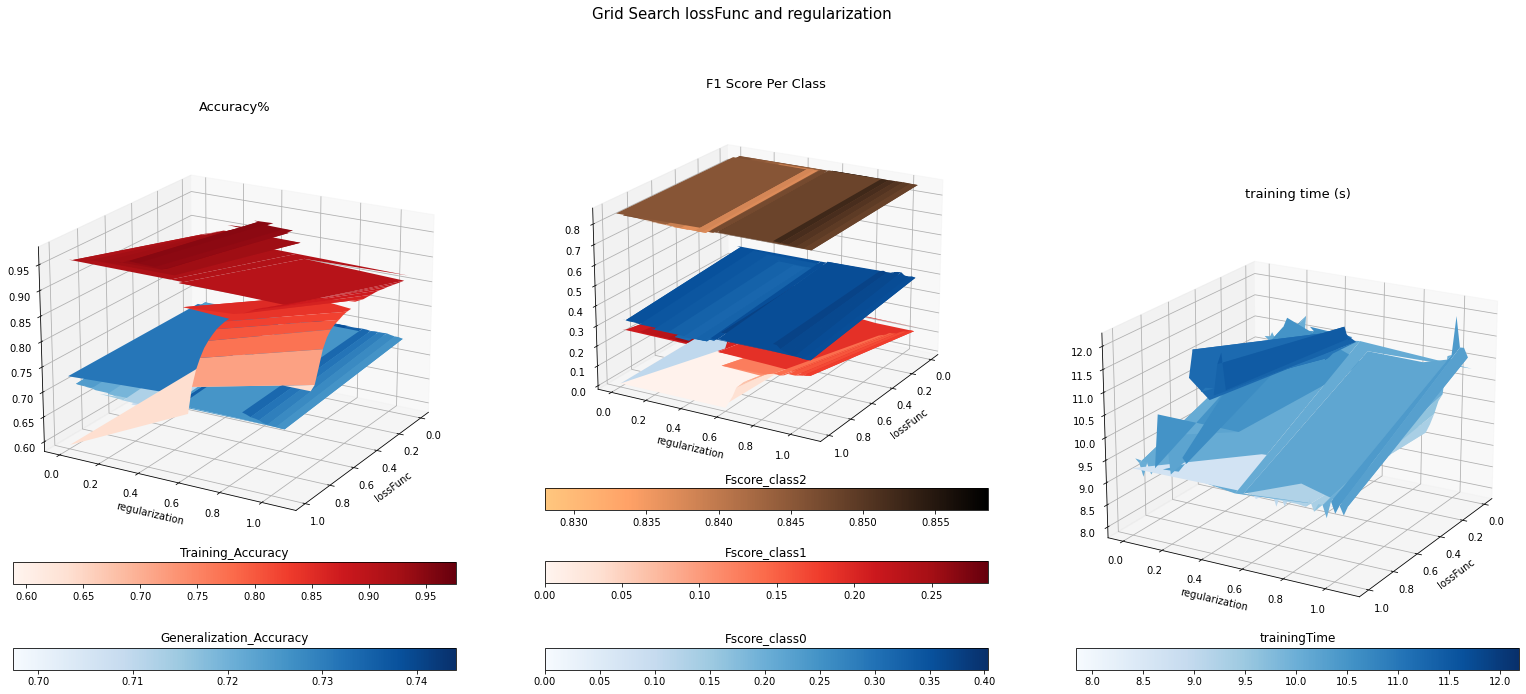

,id,Model,Cross_Validation,Kernel,degree,gamma,regularization,trainingTime,Training_Accuracy,Generalization_Accuracy,Fscore_class0,Fscore_class1,Fscore_class2,lossFunc,Penalty
61,SVM_cv5_loss_squared_hinge_penaltyl2_regular0,SVM_Linear,5,Linear,0,0,0.121,9.410942,0.853380,0.744108,0.393865,0.147082,0.858623,1,l2
60,SVM_cv5_loss_squared_hinge_penaltyl2_regular0,SVM_Linear,5,Linear,0,0,0.101,9.428039,0.838048,0.743787,0.391716,0.129341,0.858393,1,l2
59,SVM_cv5_loss_squared_hinge_penaltyl2_regular0,SVM_Linear,5,Linear,0,0,0.081,9.393360,0.817401,0.743787,0.379556,0.111731,0.857928,1,l2
57,SVM_cv5_loss_squared_hinge_penaltyl2_regular0,SVM_Linear,5,Linear,0,0,0.041,9.189543,0.758212,0.741529,0.352349,0.032495,0.854614,1,l2
6,SVM_cv5_loss_hinge_penaltyl2_regular0,SVM_Linear,5,Linear,0,0,0.121,8.680917,0.727264,0.741529,0.349939,0.000000,0.852029,0,l2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,SVM_cv5_loss_squared_hinge_penaltyl2_regular1,SVM_Linear,5,Linear,0,0,1.001,11.272525,0.974939,0.699577,0.300289,0.284091,0.829176,1,l2
106,SVM_cv5_loss_squared_hinge_penaltyl2_regular1,SVM_Linear,5,Linear,0,0,1.021,11.568761,0.975223,0.699255,0.300349,0.285926,0.828507,1,l2
108,SVM_cv5_loss_squared_hinge_penaltyl2_regular1,SVM_Linear,5,Linear,0,0,1.061,11.520976,0.976220,0.698610,0.296060,0.283779,0.828690,1,l2
107,SVM_cv5_loss_squared_hinge_penaltyl2_regular1,SVM_Linear,5,Linear,0,0,1.041,12.143451,0.975888,0.698287,0.295502,0.284066,0.828259,1,l2


In [39]:
penalty= 'l2'
C_parameter =np.arange(0.001,1.1,0.02)
parameter_NameA= 'lossFunc'
parameter_NameB =  'regularization'
LinearData = pd.DataFrame(columns=['id','Model','Cross_Validation','Kernel','degree','gamma','regularization','trainingTime','Training_Accuracy','Generalization_Accuracy','Fscore_class0','Fscore_class1','Fscore_class2','lossFunc','Penalty'])
resultLst = []


for i in range(2):
    for c in C_parameter:
        # train model
        graph = True if c%0.2==0 else False
        print('----%s = %s, %s = %.3f  ----------' %(parameter_NameA,loss,parameter_NameB,c))
        result, _ = crossValidateSVM_Linear(x_train,y_train, cvModel = kFold,regularizationC=c,graph=graph,penalty=penalty,loss=i,class_weight = None)
        resultLst.append(result)

result_linear2 = pd.DataFrame(resultLst,columns=list(LinearData.columns))        
LinearData = pd.concat([LinearData, result_linear2],axis=0) # store all results 

plot_parameter_result(parameter_NameA,LinearData)
plot_parameter_result(parameter_NameB,LinearData)
SVM_result_Linear = pd.concat([SVM_result_Linear,LinearData])
SVM_result.to_csv('SVM_result_Linear.csv', index=False)
plot_3D(parameter_NameA, parameter_NameB,LinearData,angles=(20,30))
result_linear2.sort_values(by = ['Generalization_Accuracy','Fscore_class1','Fscore_class1','Fscore_class2'], ascending=False)

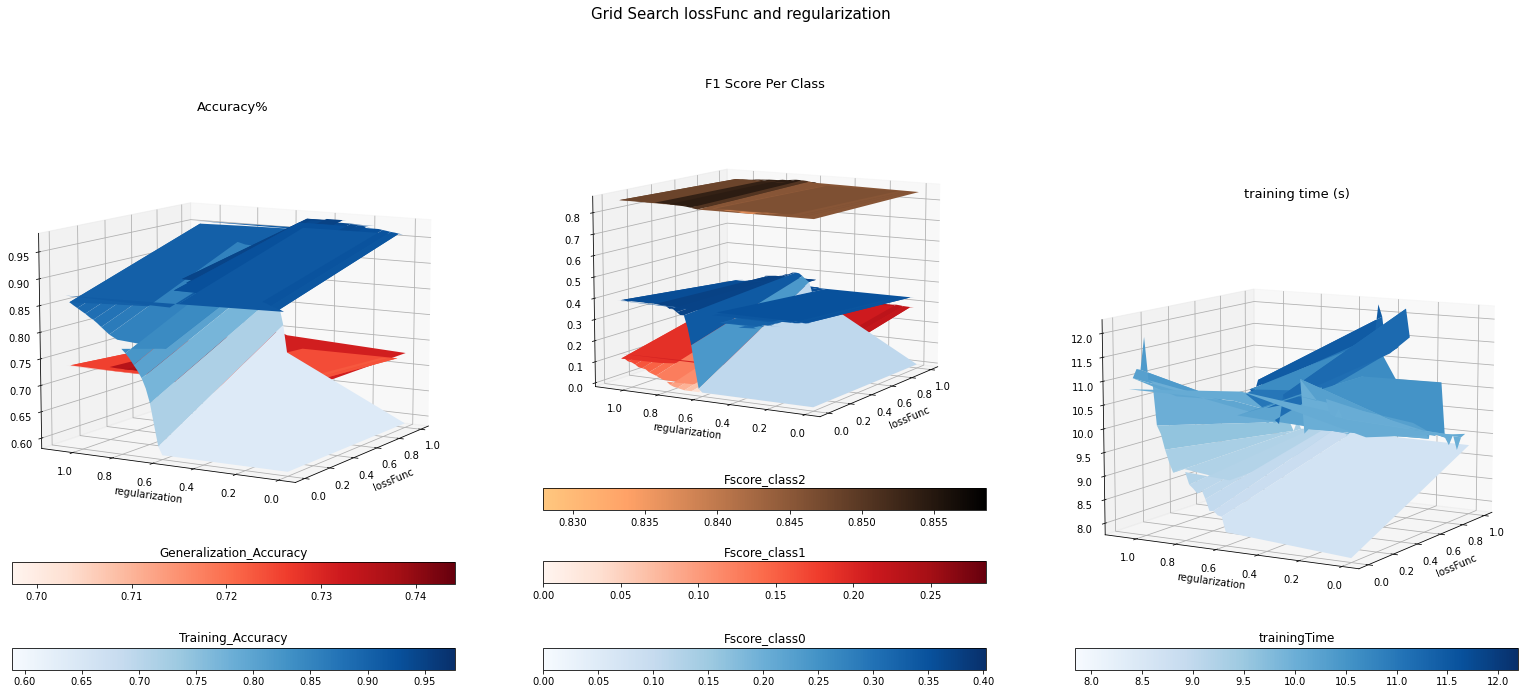

In [45]:
# Another angle
plot_3D(parameter_NameA, parameter_NameB,LinearData,angles=(10,210))

In [49]:
# Order by Performance metric # show top 30
result_linear2.sort_values(by = ['Fscore_class0','Fscore_class1','Generalization_Accuracy','Fscore_class2'], ascending=False).head(30)

,id,Model,Cross_Validation,Kernel,degree,gamma,regularization,trainingTime,Training_Accuracy,Generalization_Accuracy,Fscore_class0,Fscore_class1,Fscore_class2,lossFunc,Penalty
20,SVM_cv5_loss_hinge_penaltyl2_regular0,SVM_Linear,5,Linear,0,0,0.401,11.041415,0.836530,0.741527,0.402895,0.092094,0.858267,0,l2
19,SVM_cv5_loss_hinge_penaltyl2_regular0,SVM_Linear,5,Linear,0,0,0.381,10.998561,0.831071,0.740881,0.400736,0.080959,0.857419,0,l2
18,SVM_cv5_loss_hinge_penaltyl2_regular0,SVM_Linear,5,Linear,0,0,0.361,10.109291,0.826657,0.740882,0.397006,0.078358,0.857085,0,l2
61,SVM_cv5_loss_squared_hinge_penaltyl2_regular0,SVM_Linear,5,Linear,0,0,0.121,9.410942,0.853380,0.744108,0.393865,0.147082,0.858623,1,l2
15,SVM_cv5_loss_hinge_penaltyl2_regular0,SVM_Linear,5,Linear,0,0,0.301,9.361197,0.808383,0.741204,0.393104,0.057477,0.856482,0,l2
23,SVM_cv5_loss_hinge_penaltyl2_regular0,SVM_Linear,5,Linear,0,0,0.461,11.250959,0.850152,0.738301,0.392117,0.112964,0.856565,0,l2
62,SVM_cv5_loss_squared_hinge_penaltyl2_regular0,SVM_Linear,5,Linear,0,0,0.141,9.115884,0.866670,0.741527,0.392043,0.157056,0.856864,1,l2
60,SVM_cv5_loss_squared_hinge_penaltyl2_regular0,SVM_Linear,5,Linear,0,0,0.101,9.428039,0.838048,0.743787,0.391716,0.129341,0.858393,1,l2
17,SVM_cv5_loss_hinge_penaltyl2_regular0,SVM_Linear,5,Linear,0,0,0.341,9.935817,0.821056,0.740882,0.389624,0.075647,0.856976,0,l2
25,SVM_cv5_loss_hinge_penaltyl2_regular0,SVM_Linear,5,Linear,0,0,0.501,10.760377,0.859028,0.735074,0.389378,0.113923,0.855199,0,l2


### Grid search RBF-kernal: Regularization measure C and gamma value

In [31]:
gamma_parameter = list(np.logspace(-100,-1,20)) + ['scale']
C_parameter =np.arange(1,12,2)
parameter_NameA= 'gamma'
parameter_NameB =  'regularization'
tempData = pd.DataFrame(columns=['id','Model','Cross_Validation','Kernel','degree','gamma','regularization','trainingTime','Training_Accuracy','Generalization_Accuracy','Fscore_class0','Fscore_class1','Fscore_class2'])
resultLst = []


for gamma in gamma_parameter:
    for c in C_parameter:
        # train model
        graph = True if c%2==0 else False
        print('----%s = %s, %s = %.1f  ----------' %(parameter_NameA,str(gamma),parameter_NameB,c))
        result, _ = crossValidateSVM(x_train,y_train,'rbf', cvModel = kFold,degree=1,gamma=gamma,regularizationC=c,graph=graph)
        resultLst.append(result)

resultdf = pd.DataFrame(resultLst,columns=list(tempData.columns))        
tempData = pd.concat([tempData, resultdf],axis=0) # store all results 

tempData.loc[tempData[parameter_NameA] == 'scale',parameter_NameA] = None

plot_parameter_result(parameter_NameA,tempData)
plot_parameter_result(parameter_NameB,tempData)
SVM_result = pd.concat([SVM_result,tempData])
SVM_result.to_csv('SVM_result.csv', index=False)

----gamma = 1e-100, regularization = 1.0  ----------
-----Start Training-----
Model Training is completed
training time: 624 seconds
---Average Training Accuracy: 0.59 | Average Validation Accuracy: 0.73
Average F1 Score:
Class 0: 0.00 |  Class 1: 0.00 | Class 2: 0.84
----gamma = 1e-100, regularization = 3.0  ----------
-----Start Training-----
Model Training is completed
training time: 580 seconds
---Average Training Accuracy: 0.59 | Average Validation Accuracy: 0.73
Average F1 Score:
Class 0: 0.00 |  Class 1: 0.00 | Class 2: 0.84
----gamma = 1e-100, regularization = 5.0  ----------
-----Start Training-----
Model Training is completed
training time: 574 seconds
---Average Training Accuracy: 0.59 | Average Validation Accuracy: 0.73
Average F1 Score:
Class 0: 0.00 |  Class 1: 0.00 | Class 2: 0.84
----gamma = 1e-100, regularization = 7.0  ----------
-----Start Training-----
Model Training is completed
training time: 598 seconds
---Average Training Accuracy: 0.59 | Average Validation Accu

KeyboardInterrupt: 

#### Note: Grid search Halted as there is no improvement in any metric as follows:

In [33]:
# result interrupted for no improvement
resultdf = pd.DataFrame(resultLst,columns=list(tempData.columns))        
tempData = pd.concat([tempData, resultdf],axis=0) # store all results 

In [34]:
resultdf

,id,Model,Cross_Validation,Kernel,degree,gamma,regularization,trainingTime,Training_Accuracy,Generalization_Accuracy,Fscore_class0,Fscore_class1,Fscore_class2
0,SVM_cv5_kernel_rbf_degree1_gamma1e-100_regular1,SVM,5,rbf,1,1.000000e-100,1,624.427450,0.588381,0.727009,0.0,0.0,0.841928
1,SVM_cv5_kernel_rbf_degree1_gamma1e-100_regular3,SVM,5,rbf,1,1.000000e-100,3,580.309387,0.588381,0.727009,0.0,0.0,0.841928
2,SVM_cv5_kernel_rbf_degree1_gamma1e-100_regular5,SVM,5,rbf,1,1.000000e-100,5,574.604536,0.588381,0.727009,0.0,0.0,0.841928
3,SVM_cv5_kernel_rbf_degree1_gamma1e-100_regular7,SVM,5,rbf,1,1.000000e-100,7,598.985069,0.588381,0.727009,0.0,0.0,0.841928
4,SVM_cv5_kernel_rbf_degree1_gamma1e-100_regular9,SVM,5,rbf,1,1.000000e-100,9,563.816523,0.588381,0.727009,0.0,0.0,0.841928
5,SVM_cv5_kernel_rbf_degree1_gamma1e-100_regular11,SVM,5,rbf,1,1.000000e-100,11,580.159611,0.588381,0.727009,0.0,0.0,0.841928
6,SVM_cv5_kernel_rbf_degree1_gamma1.623776739188...,SVM,5,rbf,1,1.623777e-95,1,603.539276,0.588381,0.727009,0.0,0.0,0.841928
7,SVM_cv5_kernel_rbf_degree1_gamma1.623776739188...,SVM,5,rbf,1,1.623777e-95,3,592.514195,0.588381,0.727009,0.0,0.0,0.841928
8,SVM_cv5_kernel_rbf_degree1_gamma1.623776739188...,SVM,5,rbf,1,1.623777e-95,5,598.683011,0.588381,0.727009,0.0,0.0,0.841928
9,SVM_cv5_kernel_rbf_degree1_gamma1.623776739188...,SVM,5,rbf,1,1.623777e-95,7,598.896096,0.588381,0.727009,0.0,0.0,0.841928


----gamma = scale, regularization = 0.1  ----------
-----Start Training-----
Model Training is completed
training time: 699 seconds
---Average Training Accuracy: 0.71 | Average Validation Accuracy: 0.73
Average F1 Score:
Class 0: 0.01 |  Class 1: 0.00 | Class 2: 0.84
----gamma = scale, regularization = 0.6  ----------
-----Start Training-----
Model Training is completed
training time: 657 seconds
---Average Training Accuracy: 0.93 | Average Validation Accuracy: 0.74
Average F1 Score:
Class 0: 0.16 |  Class 1: 0.03 | Class 2: 0.85
----gamma = scale, regularization = 1.1  ----------
-----Start Training-----
Model Training is completed
training time: 651 seconds
---Average Training Accuracy: 0.99 | Average Validation Accuracy: 0.74
Average F1 Score:
Class 0: 0.18 |  Class 1: 0.12 | Class 2: 0.85
----gamma = scale, regularization = 1.6  ----------
-----Start Training-----
Model Training is completed
training time: 671 seconds
---Average Training Accuracy: 0.99 | Average Validation Accuracy

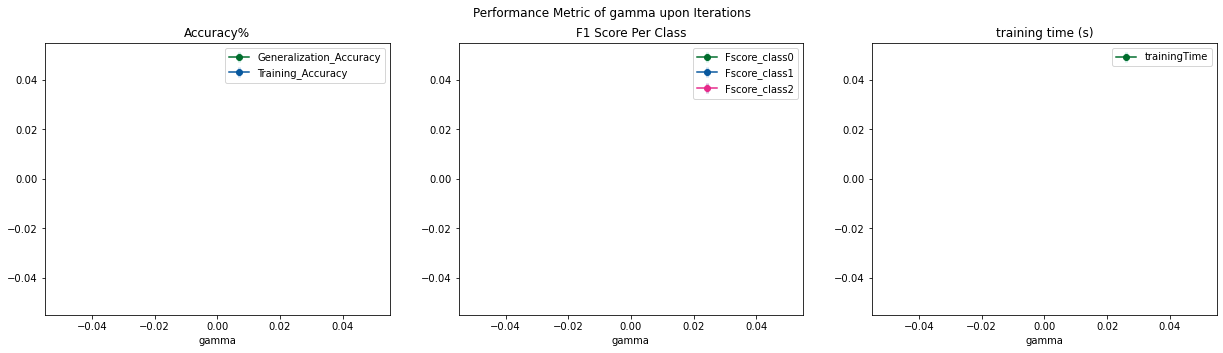

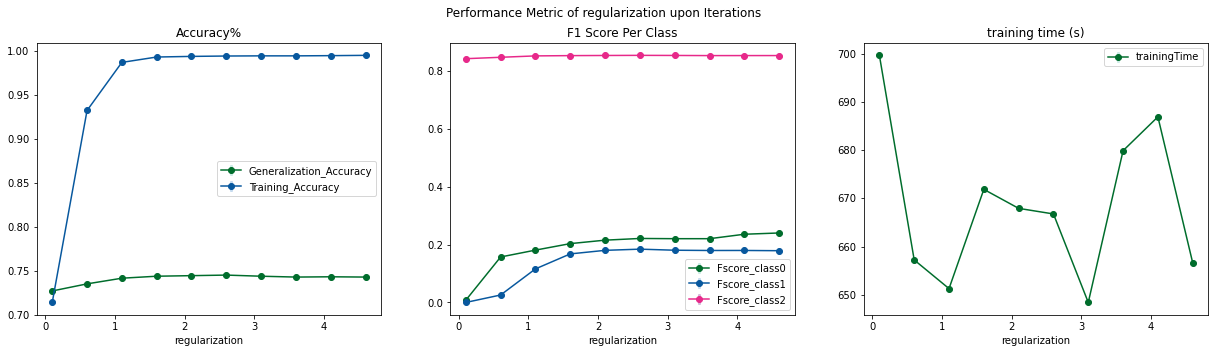

In [38]:
# assume gamma = 'scale', grid search for best C 
gamma_parameter = ['scale']
C_parameter =np.arange(0.1,5,0.5)
parameter_NameA= 'gamma'
parameter_NameB =  'regularization'
tempData = pd.DataFrame(columns=['id','Model','Cross_Validation','Kernel','degree','gamma','regularization','trainingTime','Training_Accuracy','Generalization_Accuracy','Fscore_class0','Fscore_class1','Fscore_class2'])
resultLst = []


for gamma in gamma_parameter:
    for c in C_parameter:
        # train model
        graph = True if c%2==0 else False
        print('----%s = %s, %s = %.1f  ----------' %(parameter_NameA,str(gamma),parameter_NameB,c))
        result, _ = crossValidateSVM(x_train,y_train,'rbf', cvModel = kFold,degree=1,gamma=gamma,regularizationC=c,graph=graph)
        resultLst.append(result)

resultdf = pd.DataFrame(resultLst,columns=list(tempData.columns))        
tempData = pd.concat([tempData, resultdf],axis=0) # store all results 

tempData.loc[tempData[parameter_NameA] == 'scale',parameter_NameA] = None

plot_parameter_result(parameter_NameA,tempData)
plot_parameter_result(parameter_NameB,tempData)
SVM_result = pd.concat([SVM_result,tempData])
SVM_result.to_csv('SVM_result.csv', index=False)

In [51]:
resultdf.head(10)

,id,Model,Cross_Validation,Kernel,degree,gamma,regularization,trainingTime,Training_Accuracy,Generalization_Accuracy,Fscore_class0,Fscore_class1,Fscore_class2
0,SVM_cv5_kernel_rbf_degree1_gammascale_regular0,SVM,5,rbf,1,scale,0.1,699.637102,0.713927,0.727009,0.007843,0.000000,0.842341
1,SVM_cv5_kernel_rbf_degree1_gammascale_regular0,SVM,5,rbf,1,scale,0.6,657.216210,0.932505,0.735075,0.157117,0.025729,0.847184
2,SVM_cv5_kernel_rbf_degree1_gammascale_regular1,SVM,5,rbf,1,scale,1.1,651.273047,0.987232,0.741527,0.180826,0.115938,0.851968
3,SVM_cv5_kernel_rbf_degree1_gammascale_regular1,SVM,5,rbf,1,scale,1.6,671.851072,0.993355,0.743787,0.203289,0.167756,0.852920
4,SVM_cv5_kernel_rbf_degree1_gammascale_regular2,SVM,5,rbf,1,scale,2.1,667.911273,0.994067,0.744431,0.215222,0.180032,0.853405
5,SVM_cv5_kernel_rbf_degree1_gammascale_regular2,SVM,5,rbf,1,scale,2.6,666.751985,0.994494,0.745076,0.221109,0.184176,0.853846
6,SVM_cv5_kernel_rbf_degree1_gammascale_regular3,SVM,5,rbf,1,scale,3.1,648.402864,0.994684,0.743786,0.220318,0.180458,0.853511
7,SVM_cv5_kernel_rbf_degree1_gammascale_regular3,SVM,5,rbf,1,scale,3.6,679.871269,0.994684,0.742818,0.220318,0.179548,0.853008
8,SVM_cv5_kernel_rbf_degree1_gammascale_regular4,SVM,5,rbf,1,scale,4.1,686.888241,0.994921,0.743141,0.235683,0.179647,0.853057
9,SVM_cv5_kernel_rbf_degree1_gammascale_regular4,SVM,5,rbf,1,scale,4.6,656.613453,0.995254,0.742818,0.240079,0.178779,0.853114


### Model Parameters and hyparamter confirmed: Linear Kernel, loss='squared_hinge', penalty = 'l2',C=0.121

training time: 7 seconds
---Average Training Accuracy: 0.85 | Average Validation Accuracy: 0.74
Average F1 Score:
Class 0: 0.39 |  Class 1: 0.15 | Class 2: 0.86


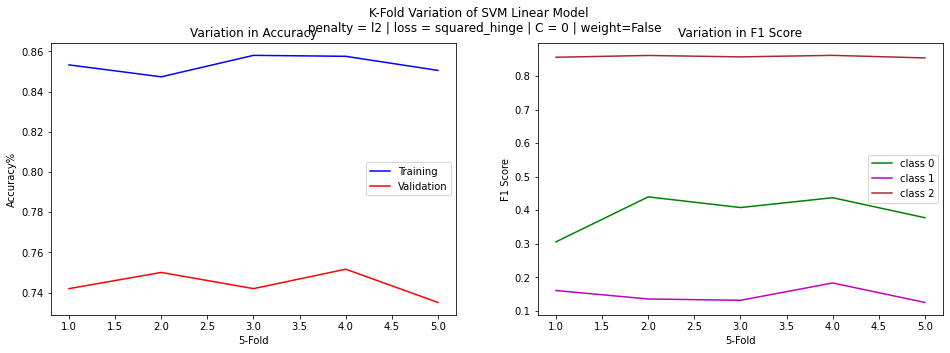

In [52]:
# final model cross validation
result_final, classifier_final = crossValidateSVM_Linear(x_train,y_train, cvModel = kFold,regularizationC=0.121,graph=True,penalty='l2',loss=1,class_weight = None)

In [65]:
# Train data for the decided parameters
from sklearn.model_selection import train_test_split
loss=1
penalty = 'l2'
regularizationC = 0.121
loss_parameter= ['hinge','squared_hinge']
ID = 'SVM__loss_%s_penalty%s_regular%d'%(loss_parameter[loss],penalty,regularizationC)


min_count =3
max_feature = 3000

vectorizer = Train_Vectorizer(full_raw,'commentsReview','benefitsReview', max_feature=max_feature, min_count=min_count)
feature = vectorizer.get_feature_names()

#Calculate the TF-IDF score of training data
df_train = text_preprocess(train_df_raw,vectorizer,'effectiveness','commentsReview','benefitsReview')

# split into 80:20 ratio
train_x,val_x,train_y, val_y = train_test_split(df_train.iloc[:,:-1],df_train.iloc[:,-1], test_size=0.2,random_state=123,stratify=df_train.iloc[:,-1])

size = train_x.shape[0]
over_proportion = '0.4;0.3;1'
over_target = dict(zip([0,1,2], [ int(x*size) for x in  [0.4,0.3,1]]))
over = SMOTE(random_state=123,sampling_strategy=over_target,k_neighbors=5)
train_x,train_y = over.fit_resample(train_x,train_y)

initime=time()
# generate model
svm_mdl = LinearSVC(random_state=123, C=regularizationC, class_weight = None,loss=loss_parameter[loss],penalty=penalty,multi_class = 'ovr', dual=True)
classifier_final = OneVsRestClassifier(svm_mdl)
      
classifier_final.fit(train_x, train_y) # fitting data
y_pred_train = classifier_final.predict(train_x)
        
# metric calculation
train_accuracy = metrics.accuracy_score(train_y,y_pred_train) # training accuracy
# validation data
y_pred_val = classifier_final.predict(val_x)
val_accuracy = metrics.accuracy_score(val_y,y_pred_val) # validation accuracy
f1_class0 = metrics.f1_score(val_y,y_pred_val,average='macro',labels=[0],zero_division=0)
f1_class1 = metrics.f1_score(val_y,y_pred_val,average='macro',labels=[1],zero_division=0)
f1_class2 = metrics.f1_score(val_y,y_pred_val,average='macro',labels=[2],zero_division=0)

print('---Training completed, training accuracy = %.3f, validation accuracy = %3f' %(train_accuracy,val_accuracy))
print('F1 Score:   Class 0: %.2f |  Class 1: %.2f | Class 2: %.2f'%(f1_class0, f1_class1, f1_class2))  
endtime = time() - initime
print('Total training time:')
print(endtime)


---Training completed, training accuracy = 0.856, validation accuracy = 0.740323
F1 Score:   Class 0: 0.33 |  Class 1: 0.13 | Class 2: 0.86
Total training time:
0.6974632740020752


### Save model

In [68]:
import pickle
with open('SVC_Final_Model.pickle','wb') as output:
    pickle.dump(classifier_final, output)
